# 第五章

## 5.1 用主成分分析实现无监督降维

### 5.1.1 主成分分析的主要步骤

#### 一般来说PCA降维的算法步骤
1.标准化d维数据集
2.构建协方差矩阵
3.将协方差矩阵分解为特征向量和特征值
4.通过降序对特征值进行排序，对相应的特征向量进行排序
5.选择对应k个最大特征值的k个特征向量，其中k为新空间的位数（k 小于等于 d）
6.从最上面的k特征向量开始构造投影矩阵W
7.用投影矩阵W变换d维输入数据集X获得新的k维特征子空间

#### 调用模块

In [108]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

sys.path.append('C:\\Users\\Administrator\\Desktop\\myself')
# import plotClassifierRegions

plt.rcParams['font.sans-serif'] = ['SimHei'] # 输出中文
plt.rcParams['axes.unicode_minus'] = False # 正负轴显示

#### 分裂为独立的训练集和测试集，并标准化单位方差

In [109]:
dfWine = pd.read_csv(r"C:\Users\86138\Desktop\myself\刷过的书\python_机器学习\wine_data.csv")
X, y = dfWine.iloc[:, 1:].values, dfWine.iloc[:, 0].values
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=.3, stratify=y, random_state=0)
sc = StandardScaler()
xTrainStd = sc.fit_transform(xTrain)
xTestStd = sc.transform(xTest)

#### 获取协方差矩阵的特征向量和特征值

In [110]:
#covMatT = np.cov(xTrainStd)
covMat = np.cov(xTrainStd.T) # 转置保证特征值与行数相同，否则，为124个特征值，与特征数量不符合
eigenVals, eigenVecs = np.linalg.eig(covMat)
#eigenValsT, eigenVecsT = np.linalg.eig(covMat)
print("特征值: \n%s" % eigenVals)

特征值: 
[4.8427 2.416  1.5485 0.9612 0.8417 0.6621 0.5183 0.3465 0.3131 0.1075
 0.2136 0.1536 0.1809]


#### 特征值的方差解释比画出来，也就是某个特征值与特征值总和之比

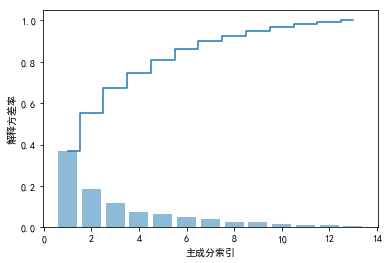

In [111]:
tot = sum(eigenVals)
varExp = [(i / tot) for i in sorted(eigenVals, reverse=True)]
cumVarExp = np.cumsum(varExp)
plt.bar(range(1,14), varExp, alpha=.5, align="center", label="独立的解释方差")
plt.step (range(1,14), cumVarExp, where="mid", label="累计的解释方差")
plt.ylabel("解释方差率")
plt.xlabel("主成分索引")
plt.show() # 前两个成分几乎占了60%

#### 特征转换
选择与前k个特征值对应的特征向量，其中k为新特征子空间的位置 k<=d
用前K个特征向量构造投影矩阵W
用投影矩阵W变换d为输入数据集X以获得新的k维特征子空间

In [112]:
eigenPairs = [(np.abs(eigenVals[i]), eigenVecs[:, i]) for i in range(len(eigenVals))]
eigenPairs.sort(key=lambda k:k[0], reverse=True)
w = np.hstack((eigenPairs[0][1][:, np.newaxis], eigenPairs[1][1][:, np.newaxis]))  # 水平合并[:,1]  [:,1]
print("Matrix W:\n", w)

Matrix W:
 [[-0.1372  0.503 ]
 [ 0.2472  0.1649]
 [-0.0255  0.2446]
 [ 0.2069 -0.1135]
 [-0.1544  0.2897]
 [-0.3938  0.0508]
 [-0.4174 -0.0229]
 [ 0.3057  0.0905]
 [-0.3067  0.0084]
 [ 0.0755  0.5498]
 [-0.3261 -0.2072]
 [-0.3686 -0.249 ]
 [-0.2967  0.3802]]


In [113]:
xTrainStd[0].dot(w) # (1,13) dot (13,2) = (1,2)

array([2.383 , 0.4546])

In [114]:
xTrainStd[0]

array([ 0.7123,  2.2205, -0.1303,  0.0596, -0.5043, -0.5283, -1.24  ,
        0.8412, -1.0522, -0.2922, -0.2002, -0.8216, -0.6295])

In [115]:
xTrainPca = xTrainStd.dot(w)

In [116]:
xTrainStd.shape

(124, 13)

In [117]:
xTrainPca.shape

(124, 2)

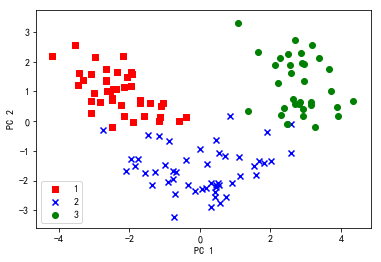

In [118]:
colors = list("rbg")
markers = list("sxo")
for l, c, m in zip(np.unique(yTrain), colors, markers):
    plt.scatter(xTrainPca[yTrain==l, 0], xTrainPca[yTrain==l, 1], c=c, label=l, marker=m)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc = "lower left")
plt.show()

#### sklearn的主成分分析

In [119]:
xTrainPca[yTrain==1, 1]

array([ 1.6538,  1.0291,  0.6024,  0.9463,  0.1388,  0.1605,  0.7175,
        1.4718,  0.7041,  2.1866,  0.5192,  0.6139,  0.7684,  1.0848,
        1.02  ,  0.0049, -0.2131,  1.1468,  1.7593,  1.3578,  1.6654,
        0.1375,  2.1698,  1.6014,  0.6005,  1.3924,  0.5287, -0.044 ,
        1.5972,  1.2143,  1.6117,  2.2015,  0.0092,  0.2829,  0.6962,
        0.6327,  1.0746,  0.1664,  1.3814,  2.5791,  1.1832])

#### 可视化函数

In [120]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    '''
    常用分类可视化函数
    param X 训练集
    param y 标签
    param classifier 已fit好的分类器
    test_idx 训练集的输入变量范围
    resolution 等高线 高度
    return 等高线 
    '''
    marker = list('sxo^v')
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=cmap(idx),
                    marker=marker[idx],
                    label=cl)


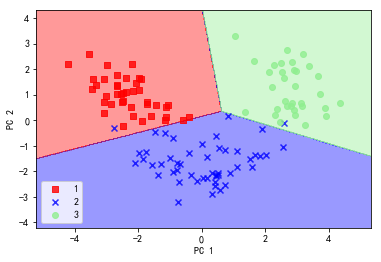

In [121]:
pca = PCA(n_components=2)
lr = LogisticRegression(solver="saga", multi_class="auto")
skTrainPca = pca.fit_transform(xTrainStd)
skTestPca = pca.transform(xTestStd)
lr.fit(skTrainPca, yTrain)
plot_decision_regions(skTrainPca, yTrain, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc = "lower left")
plt.show()

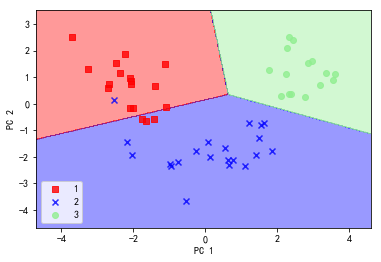

In [122]:
plot_decision_regions(skTestPca, yTest, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc = "lower left")
plt.show()

In [123]:
pca=PCA(n_components=None) # 初始化PCA类，这样可以保持所有的主成分，然后通过解释方差属性比访问
xTrainPca = pca.fit_transform(xTrainStd)
pca.explained_variance_ratio_

array([0.3695, 0.1843, 0.1182, 0.0733, 0.0642, 0.0505, 0.0395, 0.0264,
       0.0239, 0.0163, 0.0138, 0.0117, 0.0082])

### 5.2 基于线性判别分析的有监督数据压缩

#### 计算均值向量

In [124]:
np.set_printoptions(precision=4)
meanVecs = []
for label in range(1, 4):
    meanVecs.append(np.mean(xTrainStd[yTrain==label], axis=0))
    print("MV %s: %s\n" % (label, meanVecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



#### 计算类内散布矩阵

In [125]:
d = 13
SW = np.zeros((d, d))
for label, mv in zip(range(1, 4), meanVecs):
    classScatter = np.zeros((d, d))
    for row in xTrainStd[yTrain == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d,1)
        classScatter += (row - mv).dot((row - mv).T)
    SW += classScatter
print("Within-class scatter matrix: %sx%s" % (SW.shape[0], SW.shape[1]))

Within-class scatter matrix: 13x13


#### 训练集中的分类标签均匀分布

In [126]:
print("Class label distribution: %s" % np.bincount(yTrain)[1:])

Class label distribution: [41 50 33]


#### 计算类间散布矩阵

In [127]:
meanOverall = np.mean(xTrainStd, axis=0)
d = 13
SB = np.zeros((d,d))
for i, meanVec in enumerate(meanVecs):
    n = xTrain[yTrain == i + 1, :].shape[0]
    meanVec = meanVec.reshape(d, 1)
    meanOverall = meanOverall.reshape(d, 1)
    SB += n * (meanVec - meanOverall).dot((meanVec - meanOverall).T)
print("Between-class scatter matrix: %sx%s" % (SB.shape[0], SB.shape[1]))

Between-class scatter matrix: 13x13


#### 在新的特征子空间选择线性判别式

In [128]:
eigenVals, eigenVecs = np.linalg.eig(np.linalg.inv(SW).dot(SB))
eigenPairs = [(np.abs(eigenVals[i]), eigenVecs[:, i]) for i in range(len(eigenVals))]
eigenPairs = sorted(eigenPairs, key=lambda k:k[0], reverse=True)
print("EigenValues in descending order: \n")
for eigenVal in eigenPairs:
    print(eigenVal[0]) # 近似只有两个非零特征值（浮点运算）

EigenValues in descending order: 

8.262493673957483
4.225659486916686
9.2755649547541e-16
5.788968521986873e-16
3.4207348338517877e-16
3.4207348338517877e-16
2.863361199026827e-16
1.5487290843285566e-16
1.5487290843285566e-16
1.4255070709476658e-16
1.4255070709476658e-16
8.914491057314394e-17
0.0


#### 可视化主成分占比

D:\ssoftware\anaconda\lib\site-packages\matplotlib\transforms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
D:\ssoftware\anaconda\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


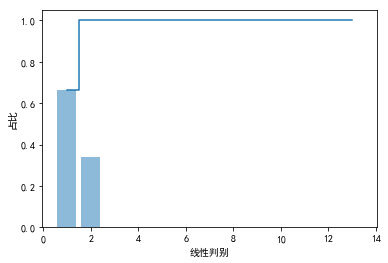

In [129]:
tot = sum(eigenVals.real)
varExp = [(i / tot) for i in sorted(eigenVals, reverse=True)]
cumVarExp = np.cumsum(varExp)
plt.bar(range(1,14), varExp, alpha=.5, align="center", label="累计")
plt.step (range(1,14), cumVarExp, where="mid", label="独立") # where?
plt.ylabel("占比")
plt.xlabel("线性判别")
plt.show() # 前两个成分几乎占了100%（62%+38%）

In [130]:
w = np.hstack((eigenPairs[0][1][:, np.newaxis].real, eigenPairs[1][1][:, np.newaxis].real))
print("Matrix W:\n", w)

Matrix W:
 [[-0.1586 -0.4077]
 [ 0.0984 -0.1821]
 [-0.0156 -0.3473]
 [ 0.1588  0.3095]
 [-0.0207 -0.064 ]
 [ 0.1884  0.0733]
 [-0.7153  0.3034]
 [-0.0798 -0.0009]
 [ 0.0074  0.0716]
 [ 0.3448 -0.2808]
 [-0.0254  0.244 ]
 [-0.3192 -0.0459]
 [-0.4054 -0.5806]]


#### 将样本投影到新的特征空间

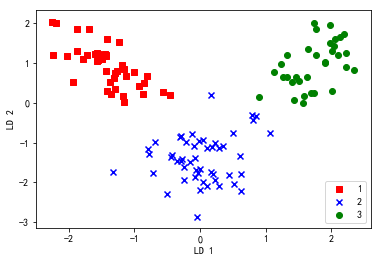

In [131]:
xTrainLda = xTrainStd.dot(w)
colors = list("rbg")
markers = list("sxo")
for l, c, m in zip(np.unique(yTrain), colors, markers):
    plt.scatter(xTrainLda[yTrain==l, 0], xTrainLda[yTrain==l, 1] * (-1), c=c, label=l, marker=m)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc = "lower right")
plt.show()

#### 用sk实现LDA

In [132]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
xTrainLda = lda.fit_transform(xTrainStd, yTrain)

#### LDA变换后的低维训练集在逻辑回归分类器的表现

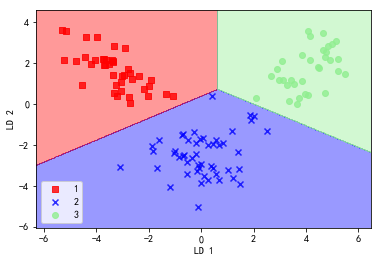

In [133]:
lr = LogisticRegression(solver="saga", multi_class="auto",max_iter=1000)
lr = lr.fit(xTrainLda, yTrain)
plot_decision_regions(xTrainLda, yTrain, classifier=lr)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc = "lower left")
plt.show()

#### LDA在测试集的表现

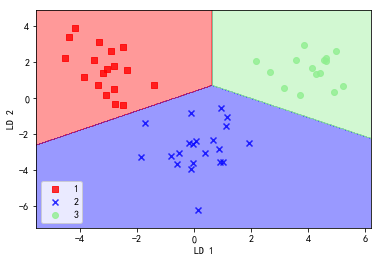

In [134]:
xTestLda = lda.transform(xTestStd)
plot_decision_regions(xTestLda, yTest, classifier=lr)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc = "lower left")
plt.show() # 无错误分类

### 5.3.2 用python实现核主成分分析

In [135]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [145]:
def rbfKernelPCA(X, gamma, n_components):
    # 第一步
    sqDist = pdist(X, "sqeuclidean") # ‖x(i) - x(j)‖
    matSqDists = squareform(sqDist) # (‖x(i) - x(j)‖)平方
    k = exp(-gamma * matSqDists) # exp(-γ *（(‖x(i) - x(j)‖)平方）)
    # 第二部
    n = k.shape[0]
    oneN = np.ones((n, n)) / n
    k = k - oneN.dot(k) - k.dot(oneN) + oneN.dot(k).dot(oneN)
    # 第三步
    eigvals, eigvecs = eigh(k)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    alphas = np.column_stack((eigvecs[:, i] for i in  range(n_components)))
    
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas

#### 案例1：分离半月形

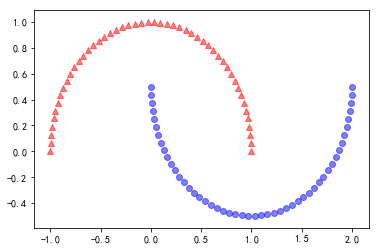

In [137]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=.5)
plt.show()

#### 标准的PCA数据集投影到主成分上

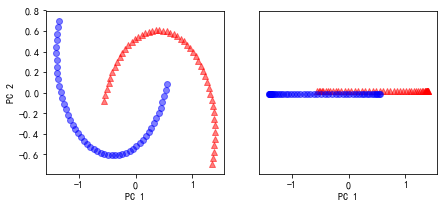

In [138]:
from sklearn.decomposition import PCA
scikitPCA = PCA(n_components=2)
xFitTransform = scikitPCA.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(xFitTransform[y==0, 0], xFitTransform[y==0,1],color="red", marker="^", alpha=.5)
ax[0].scatter(xFitTransform[y==1, 0], xFitTransform[y==1,1],color="blue", marker="o", alpha=.5)
ax[1].scatter(xFitTransform[y==0, 0], np.zeros((50,1))+.02, color="red", marker="^", alpha=.5)
ax[1].scatter(xFitTransform[y==1, 0], np.zeros((50,1))-.02, color="blue", marker="o", alpha=.5)
ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([]) # 直接把刻度隐藏了
ax[1].set_xlabel("PC 1")
plt.show()

#### 使用核主成分分析函数rbfKernelPCA

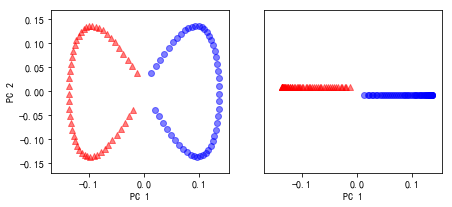

In [139]:
xFitTransform = rbfKernelPCA(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(xFitTransform[y==0, 0], xFitTransform[y==0,1],color="red", marker="^", alpha=.5)
ax[0].scatter(xFitTransform[y==1, 0], xFitTransform[y==1,1],color="blue", marker="o", alpha=.5)
ax[1].scatter(xFitTransform[y==0, 0], np.zeros((50,1))+.05, color="red", marker="^", alpha=.5)
ax[1].scatter(xFitTransform[y==1, 0], np.zeros((50,1))-.05, color="blue", marker="o", alpha=.5)
ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([]) # 直接把刻度隐藏了
ax[1].set_xlabel("PC 1")
plt.show()

#### 5.3.2.2 案例2-分离同心圆

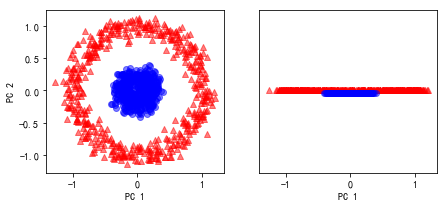

In [140]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=.2)
scikitPCA = PCA(n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=.5)
ax[0].scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=.5)
ax[1].scatter(X[y==0, 0], np.zeros((500,1)) + .02, color='red', marker='^', alpha=.5)
ax[1].scatter(X[y==1, 0], np.zeros((500,1)) - .02, color='blue', marker='o', alpha=.5)
ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([]) # 直接把刻度隐藏了
ax[1].set_xlabel("PC 1")
plt.show()

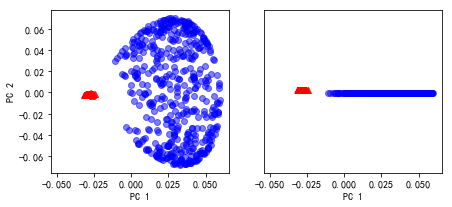

In [141]:
X1 = rbfKernelPCA(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X1[y==0, 0], X1[y==0, 1], color='red', marker='^', alpha=.5)
ax[0].scatter(X1[y==1, 0], X1[y==1, 1], color='blue', marker='o', alpha=.5)
ax[1].scatter(X1[y==0, 0], np.zeros((500,1)) + .02, color='red', marker='^', alpha=.5)
ax[1].scatter(X1[y==1, 0], np.zeros((500,1)) - .02, color='blue', marker='o', alpha=.5)
ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([]) # 直接把刻度隐藏了
ax[1].set_xlabel("PC 1")
plt.show()

#### 投影新的数据点

In [146]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbfKernelPCA(X, gamma=15, n_components=1) # 用更新后的RBF核PCA将其投影到一维子空间

In [149]:
alphas.shape

(100, 1)

In [150]:
lambdas

[7.0627247566799545]

In [151]:
xNew = X[25]

In [152]:
xNew # 将其投射到新的子空间

array([1.8713, 0.0093])

In [153]:
xProj = alphas[25]

In [154]:
xProj

array([0.0788])

In [158]:
def projectX(xNew, X, gamma, alphas, lambdas):
    pairDist = np.array([np.sum((xNew - row) ** 2 ) for row in X])
    k = np.exp(-gamma * pairDist)
    return k.dot(alphas / lambdas)


In [159]:
xReproj = projectX(xNew, X, gamma=15, alphas=alphas, lambdas=lambdas)

In [160]:
xReproj

array([0.0788])

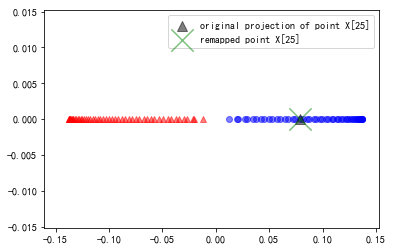

In [161]:
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='red', marker='^', alpha=.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='blue', marker='o', alpha=.5)
plt.scatter(xProj, 0, color='black', marker='^', alpha=.5, s=100, label="original projection of point X[25]")
plt.scatter(xReproj, 0, color='green', marker='x', alpha=.5, s=500, label="remapped point X[25]")
plt.legend(scatterpoints=1)

##### 5.3.4 sklearn核主成分分析

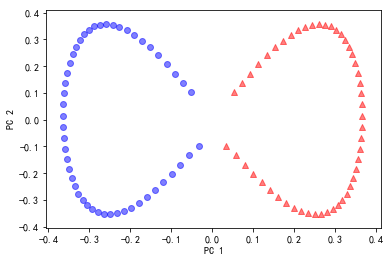

In [162]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples=100, random_state=134)
scikitKpca = KernelPCA(n_components=2, kernel="rbf", gamma=15)
xSkearnPCA = scikitKpca.fit_transform(X)
plt.scatter(xSkearnPCA[y==0, 0], xSkearnPCA[y==0, 1], color="red", marker="^", alpha=.5)
plt.scatter(xSkearnPCA[y==1, 0], xSkearnPCA[y==1, 1], color="blue", marker="o", alpha=.5)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()